In [1]:
import tempfile
from urllib.request import urlretrieve
import sys
import shutil
from distutils.dir_util import copy_tree

from google.colab import drive,files
drive.mount('/content/drive')
os.makedirs("/content/5lsl0_MLSP")
ROOT_DIR = "/content/5lsl0_MLSP"
copy_tree("/content/5lsl0_MLSP",""/content/drive/TUe/5lsl0_MLSP")


SyntaxError: invalid syntax (<ipython-input-1-f13b8980e1f9>, line 11)

In [2]:
from MNIST_dataloader import create_dataloaders
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

## Exercise 1

In [9]:
torch.random.manual_seed(0)
data_loc = os.path.join(os.path.abspath("."),"MNIST")
batch_size = 16
train_loader, test_loader = create_dataloaders(data_loc,batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels
x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels
# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

In [10]:
import torchvision.transforms.functional as TF
from PIL import Image
# TF.to_pil_image(x_clean_example[1,:,:,:]).show()
print(torch.max(x_clean_example[:,:,:,:]).item())
print(torch.min(x_clean_example[:,:,:,:]).item())

1.0
-1.0


In [11]:
def softthreshold(x,shrinkage):

    return torch.multiply(torch.sign(x),torch.max(torch.abs(x)-shrinkage,torch.zeros_like(x)))

def ISTA(mu,lambd,k,y:torch.tensor)->torch.tensor:
    """
    INPUT:
    mu:     step size                (float32)
    lambd:  shrinkage parmater       (float32)
    k:      number of iteration      (int)
    y:      measurements             (tensor)
    -----------------------------------------------
    OUTPUT:
    reconstruction: recons           (tensor)
    """
    y_shape = y.shape
    y = y.flatten() + 1
    A = torch.eye(y.shape[0])
    x_1 = torch.zeros_like(y)
    for i in range(k):
        g_1 = A.T@(y-A@x_1)
        x_2 = x_1 + mu * g_1
        x_hat = softthreshold(x_2,lambd*mu)
        # x_hat = torch.tanh(x_hat)
        error = torch.nn.functional.mse_loss(x_hat,x_1)
        if error < 1e-8:
            break
        else:
            x_1 = x_hat
    recons = x_hat.reshape(y_shape) - 1
    # return recons, x_hat, error,i
    return recons

mu = 0.5
lambd = 0.9

k = 1000


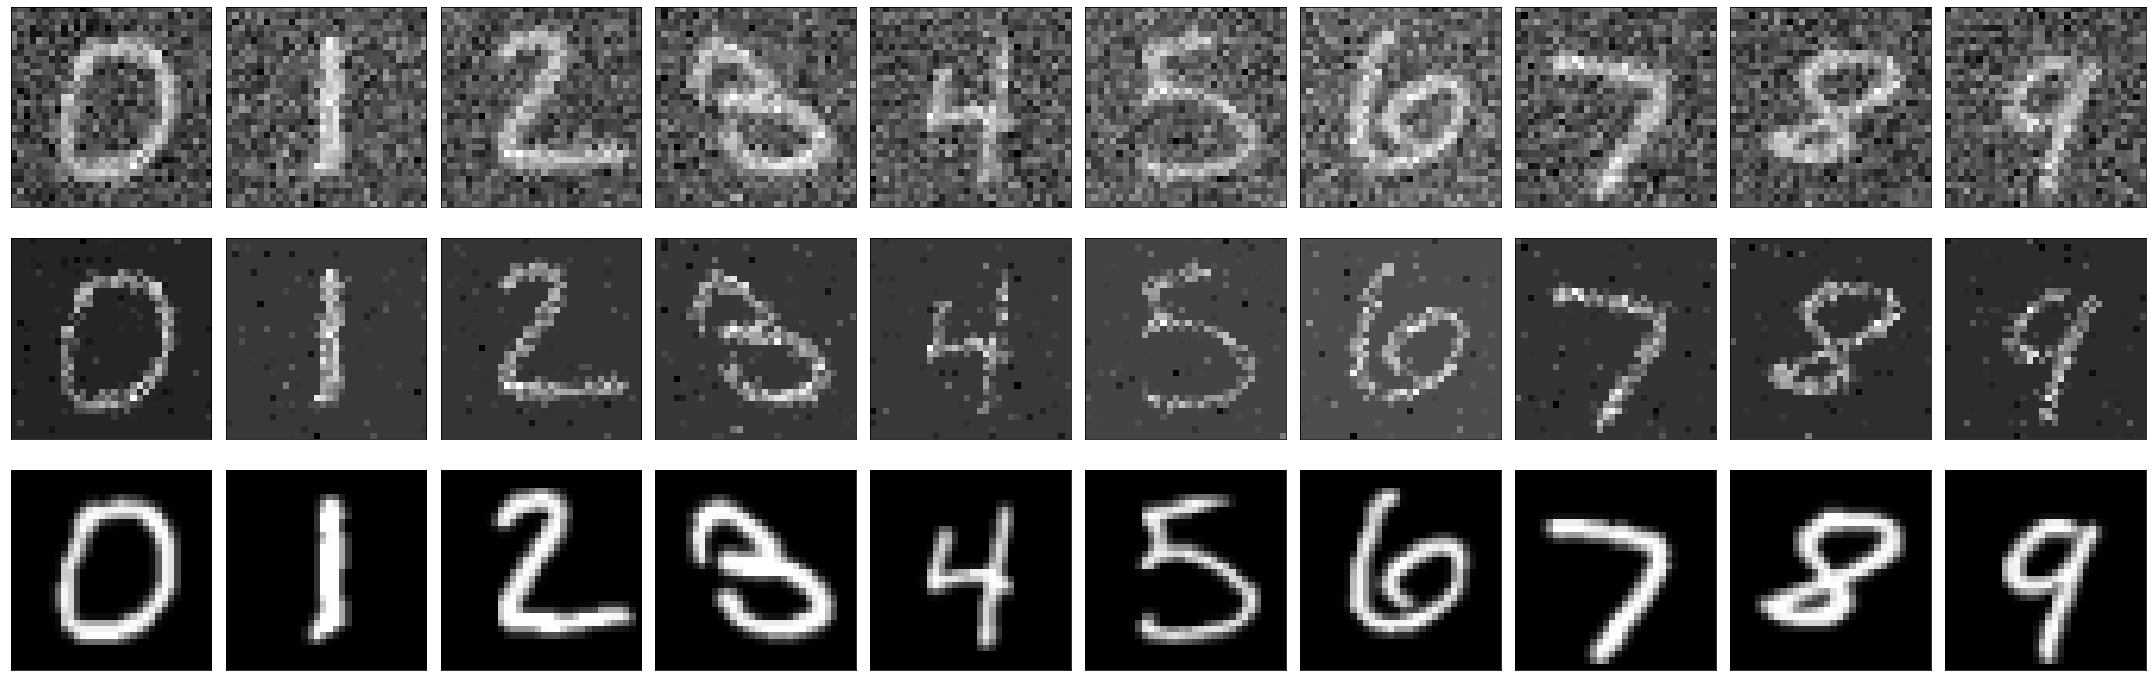

In [13]:
reconses = torch.zeros((10,1,x_noisy_example.shape[-1],x_noisy_example.shape[-1]))

plt.figure(figsize=(30,10))
for ii in range(10):
    reconses[ii,:,:,:] = ISTA(mu,lambd,k,x_noisy_example[ii,:,:,:])
    plt.subplot(3,10,ii+1)
    plt.imshow(x_noisy_example[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,ii+11)
    plt.imshow(reconses[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,ii+21)
    plt.imshow(x_clean_example[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath('.'),"figure")
if os.path.exists(fig_path):
    pass
else:
    os.makedirs(fig_path)
plt.savefig(os.path.join(fig_path,"w1e1.png"),dpi=80,bbox_inches='tight')
plt.show()

It can be observed that the noise on background is mostly cancelled, while the noise on the digits is partially cancelled. An argument for this is that one is added to the pixels on noisy examples to make the pixel value range from (-1,1) change to (0,2). This makes the value of the background part, which is also the main partm become 0. By giving $\lambda = 1$, the reconstructed tensor is pushed to be more sparse, i.e. closer to 0. 

In [14]:
# calculating MSE on the entire test set
import sys
from tqdm import tqdm
MSE = 0

sys.stdout.flush()
for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(test_loader)):
    if batch_idx == 0:
        print("batch idx starts with 0")
    reconses= ISTA(mu,lambd,k,x_noisy)
    MSE += torch.nn.functional.mse_loss(reconses,x_clean)
sys.stdout.flush()
MSE /= batch_idx


  0%|          | 0/625 [00:00<?, ?it/s]

batch idx starts with 0


100%|██████████| 625/625 [13:56<00:00,  1.34s/it]


In [15]:
print(MSE)

tensor(0.1541)


## Exercise 2

In [23]:
import torch.nn as nn
class smoother(nn.Module):
    def __init__(self):
        super(smoother,self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1))
        self.reset_parameters()
    
    def reset_parameters(self):
        self.weight.data.uniform_(-1,1)
    
    def forward(self,x):
        x += 0.5 * (torch.sqrt((x-self.weight)**2+1)-torch.sqrt((x+self.weight)**2+1))
        return x

In [24]:
class LISTA(nn.Module):
    def __init__(self):
        super(LISTA,self).__init__()
        self.conv1x = nn.Conv2d(1,1,3,padding=1)
        self.conv1y = nn.Conv2d(1,1,3,padding=1)
        self.smoother1 = smoother()
        self.conv2x = nn.Conv2d(1,1,3,padding=1)
        self.conv2y = nn.Conv2d(1,1,3,padding=1)
        self.smoother2 = smoother()
        self.conv3x = nn.Conv2d(1,1,3,padding=1)
        self.conv3y = nn.Conv2d(1,1,3,padding=1)
        self.smoother3 = smoother()
    
    def forward(self,y):
        x_0 = torch.zeros_like(y)
        x_1 = self.conv1x(x_0)
        y_1 = self.conv1y(y)
        recons_1 = self.smoother1(x_1+y_1)
        x_2 = self.conv2x(recons_1)
        y_2 = self.conv2y(y)
        recons_2 = self.smoother1(x_2+y_2)
        x_3 = self.conv3x(x_2)
        y_3 = self.conv3y(y)
        recons_3 = self.smoother1(x_3+y_3)
        return recons_3
        

In [32]:
## train here

loss_iter = []
loss_epoch = []
model_LISTA = LISTA()
no_epochs = 10
learning_rate = 3e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model_LISTA.parameters(),lr = learning_rate)
critereon = nn.MSELoss()
for epoch in range(no_epochs):
    total_loss = 0
    sys.stdout.flush()
    for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = x_noisy.to(device=device)
        model_LISTA = model_LISTA.to(device=device)
        outputs = model_LISTA(inputs)
        loss = critereon(outputs,x_clean)
        loss.backward()
        optimizer.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],MSE loss:{total_loss/len(train_loader)}')
    sys.stdout.flush()


100%|██████████| 3750/3750 [00:22<00:00, 168.71it/s]

epoch[1/10],MSE loss:0.18187743425369263



100%|██████████| 3750/3750 [00:22<00:00, 167.55it/s]

epoch[2/10],MSE loss:0.032502103596925735



100%|██████████| 3750/3750 [00:22<00:00, 166.81it/s]

epoch[3/10],MSE loss:0.01769750379025936



100%|██████████| 3750/3750 [00:22<00:00, 167.46it/s]

epoch[4/10],MSE loss:0.015435698442161083



100%|██████████| 3750/3750 [00:22<00:00, 166.46it/s]

epoch[5/10],MSE loss:0.01488875038921833



100%|██████████| 3750/3750 [00:22<00:00, 165.86it/s]

epoch[6/10],MSE loss:0.014712352305650711



100%|██████████| 3750/3750 [00:22<00:00, 169.59it/s]

epoch[7/10],MSE loss:0.014651576988399029



100%|██████████| 3750/3750 [00:22<00:00, 166.99it/s]

epoch[8/10],MSE loss:0.014619310386478901



100%|██████████| 3750/3750 [00:22<00:00, 168.03it/s]

epoch[9/10],MSE loss:0.014595940709114075



100%|██████████| 3750/3750 [00:22<00:00, 163.64it/s]

epoch[10/10],MSE loss:0.014576271176338196


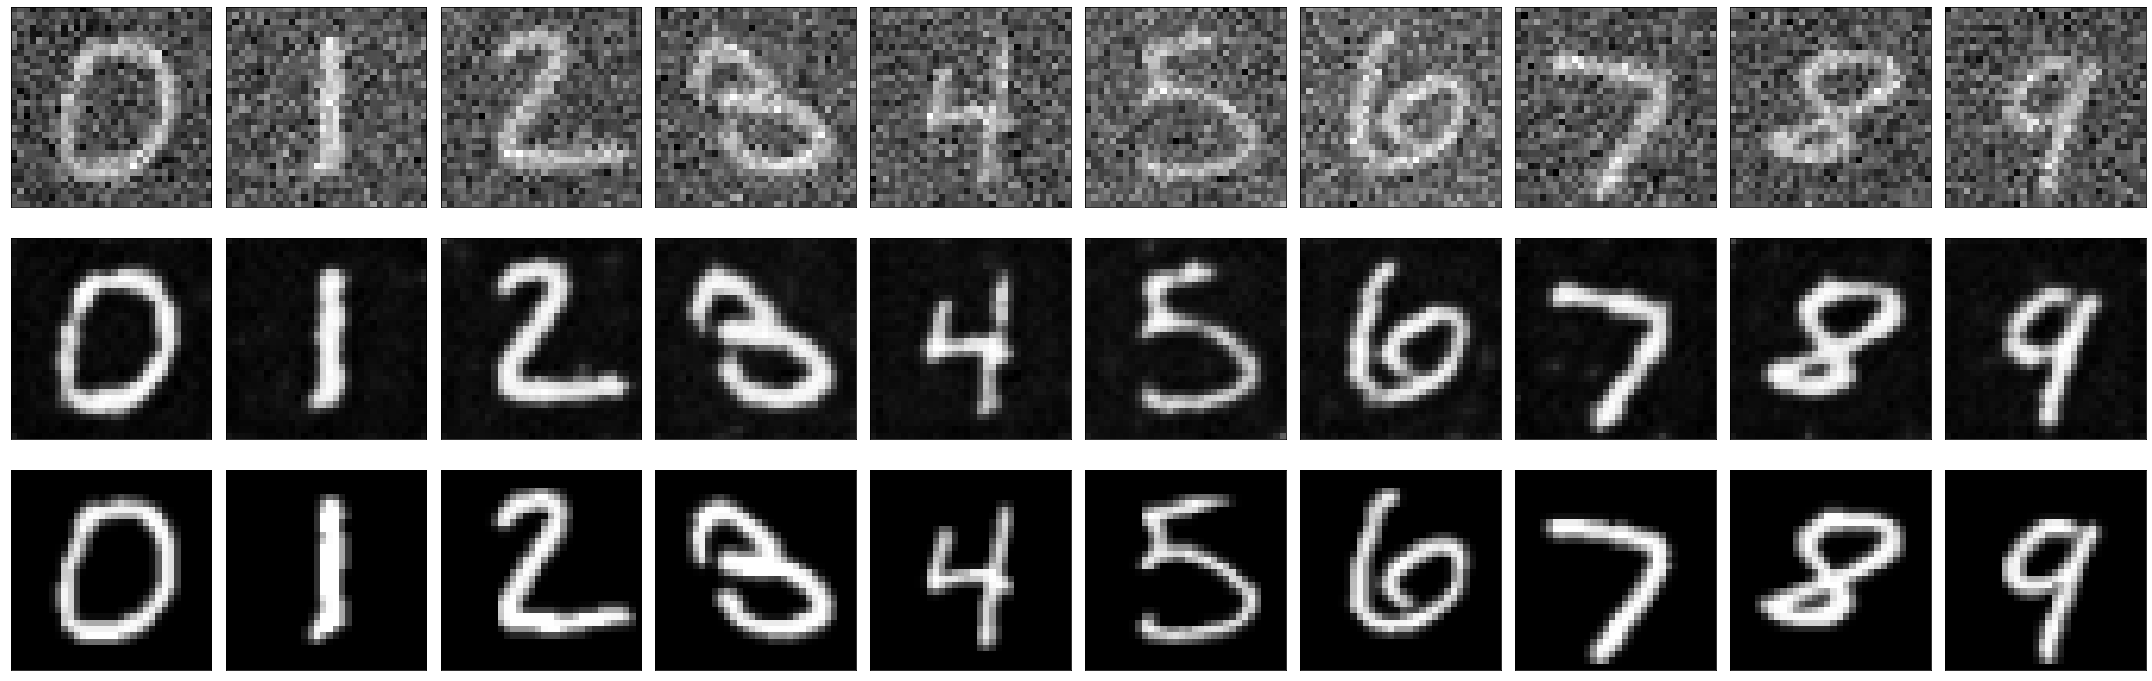

In [38]:
plt.figure(figsize=(30,10))

for ii in range(10):
    reconses[ii,:,:,:] = model_LISTA(x_noisy_example[ii,:,:,:])
    reconses = reconses.detach()
    plt.subplot(3,10,ii+1)
    plt.imshow(x_noisy_example[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,ii+11)
    plt.imshow(reconses[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,ii+21)
    plt.imshow(x_clean_example[ii,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath('.'),"figure")
if os.path.exists(fig_path):
    pass
else:
    os.makedirs(fig_path)
plt.savefig(os.path.join(fig_path,"w1e2q1.png"),dpi=80,bbox_inches='tight')
plt.show()

In [36]:
model_loc = os.path.join(os.path.abspath("."),"model")
torch.save(model_LISTA,os.path.join(model_loc,"LISTA.ptg"))

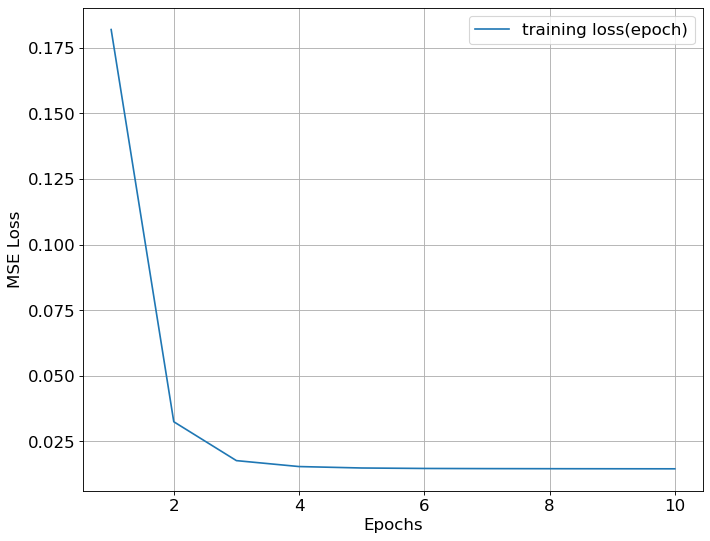

In [39]:
plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.plot(range(len(loss_iter)),loss_iter,label='training loss(iteration)',linestyle=':')
plt.plot(range(1,no_epochs+1),loss_epoch,label='training loss(epoch)',linestyle='-')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("MSE Loss",fontdict={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"w1e2__loss_plot.png"),dpi=80,bbox_inches='tight')

plt.show()

### 2c)

In [42]:
MSE = 0
model_LISTA = torch.load(os.path.join(model_loc,"LISTA.ptg"))
sys.stdout.flush()
for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(test_loader)):
    if batch_idx == 0:
        print("batch idx starts with 0")
    reconses= model_LISTA(x_noisy)
    MSE += torch.nn.functional.mse_loss(reconses,x_clean)
sys.stdout.flush()
MSE /= batch_idx
print(MSE.item())

  5%|▌         | 32/625 [00:00<00:01, 308.21it/s]

batch idx starts with 0


100%|██████████| 625/625 [00:02<00:00, 309.12it/s]

0.01436609961092472


### 2d)
The non-linear activation is the smoother conterpart of the standard soft threshholding $\tau(x,\lambda) = x + 0.5*(...)$